In [55]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from sklearn.metrics import confusion_matrix

from datetime import datetime
import itertools

In [43]:
train_dataset = torchvision.datasets.MNIST(root=".", 
                           train=True, 
                           transform=transforms.ToTensor(), 
                           download=True)
print(train_dataset.data.shape)

test_dataset = torchvision.datasets.MNIST(root=".", 
                                          train=False, 
                                          transform=transforms.ToTensor(), 
                                          download=True)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [44]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [45]:
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.L = n_rnnlayers
    self.K = n_outputs
    
    self.rnn = nn.LSTM(input_size=self.D, 
                       hidden_size=self.M, 
                       num_layers=self.L, 
                       batch_first=True)
    self.fc = nn.Linear(in_features=self.M, 
                        out_features=self.K)
    
  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, _ = self.rnn(X, (h0, c0))
    out = self.fc(out[:, -1, :])

    return out

In [46]:
model = RNN(28, 128, 2, 10)

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [49]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for epoch in range(n_epochs):

  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.view(-1, 28, 28)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, targets)
    train_loss.append(loss.item())

    loss.backward()
    optimizer.step()
  train_loss = np.mean(train_loss)
  train_losses[epoch] = train_loss

  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())

  test_loss = np.mean(test_loss)
  test_losses[epoch] = test_loss

  print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/10, Train Loss: 0.5425, Test Loss: 0.1627
Epoch 2/10, Train Loss: 0.1305, Test Loss: 0.0928
Epoch 3/10, Train Loss: 0.0823, Test Loss: 0.0777
Epoch 4/10, Train Loss: 0.0618, Test Loss: 0.0556
Epoch 5/10, Train Loss: 0.0489, Test Loss: 0.0617
Epoch 6/10, Train Loss: 0.0412, Test Loss: 0.0433
Epoch 7/10, Train Loss: 0.0341, Test Loss: 0.0447
Epoch 8/10, Train Loss: 0.0336, Test Loss: 0.0404
Epoch 9/10, Train Loss: 0.0261, Test Loss: 0.0420
Epoch 10/10, Train Loss: 0.0255, Test Loss: 0.0362


[]

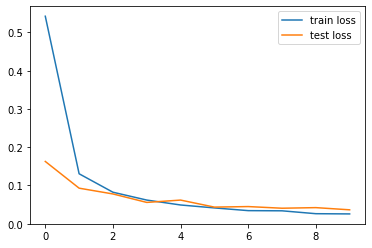

In [50]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.plot()

In [51]:
n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 28, 28)

  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 28, 28)

  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

In [52]:
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9948, Test acc: 0.9894


In [56]:
def plot_confucsion_matrix(cm, classes, 
                           normalize=False,
                           title="Confusion Matrix", 
                           cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")    

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),   
                 horizontalalignment="center",           
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

Confusion matrix, without normalization
[[ 975    0    0    0    0    0    3    1    1    0]
 [   0 1134    0    0    0    0    1    0    0    0]
 [   2    2 1021    1    1    0    1    0    3    1]
 [   0    0    1 1003    0    1    0    0    3    2]
 [   0    0    2    0  970    0    4    1    0    5]
 [   2    0    0    6    0  878    2    0    1    3]
 [   2    2    0    0    2    2  948    0    2    0]
 [   0    2    8    1    0    0    0 1012    1    4]
 [   0    0    1    1    1    2    0    3  966    0]
 [   1    0    0    2   13    1    0    3    2  987]]


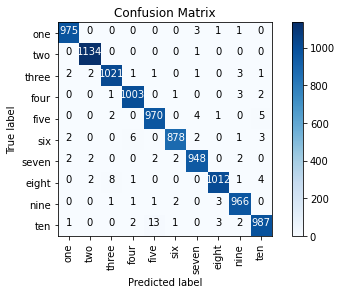

In [59]:
labels = """one
two
three
four
five
six
seven
eight
nine
ten""".split("\n")

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    inputs = inputs.to(device)

    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    _, predictions = torch.max(outputs, 1)

    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confucsion_matrix(cm, labels)

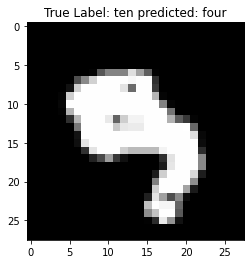

In [67]:
misclassifed_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassifed_idx)
plt.imshow(x_test[i], cmap="gray")
plt.title("True Label: %s predicted: %s" % (labels[y_test[i]], labels[int(p_test[i])]))
plt.show()